In [1]:
USER_CIFAR_BASEPATH = r"C:\Users\Liang\OneDrive - Nanyang Technological University\Documents\AIDM\datasets\cifar-10-batches-py"

FALLBACK_LOCAL_BASEPATH = "/mnt/data/cifar-10-batches-py"

VAL_SPLIT = 0.1

img_size = 224
epochs = 20
batch_size = 64
learning_rate = 3e-4
weight_decay = 0.05
warmup_epochs = 5
label_smoothing = 0.1
mixup_alpha = 0.2
cutmix_alpha = 0.2
random_erasing_p = 0.1

NUM_WORKERS = 2
RANDOM_SEED = 42
SAVE_BEST_TO = "best_convnext_tiny_cifar10.pt"

print("Configured CIFAR path:", USER_CIFAR_BASEPATH)
print("epochs:", epochs, "| batch_size:", batch_size, "| lr:", learning_rate, "| weight_decay:", weight_decay)
print("warmup_epochs:", warmup_epochs, "| label_smoothing:", label_smoothing, "| mixup_alpha:", mixup_alpha, "| cutmix_alpha:", cutmix_alpha)

Configured CIFAR path: C:\Users\Liang\OneDrive - Nanyang Technological University\Documents\AIDM\datasets\cifar-10-batches-py
epochs: 20 | batch_size: 64 | lr: 0.0003 | weight_decay: 0.05
warmup_epochs: 5 | label_smoothing: 0.1 | mixup_alpha: 0.2 | cutmix_alpha: 0.2


In [2]:
import os, sys, math, time, random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms, models

def set_seed(seed: int = 42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
import timm
from timm.data import Mixup
from timm.loss import SoftTargetCrossEntropy
from timm.utils import ModelEmaV2
from timm.scheduler.cosine_lr import CosineLRScheduler
from torch.cuda.amp import GradScaler

In [3]:
import os

def resolve_cifar_root(user_basepath: str, local_fallback: str):
    if user_basepath and os.path.isdir(user_basepath):
        base = user_basepath
        parent = os.path.dirname(base.rstrip("\\/"))
        if os.path.basename(base.rstrip("\\/")) == "cifar-10-batches-py":
            if os.path.isdir(base):
                return parent
        if os.path.isdir(os.path.join(user_basepath, "cifar-10-batches-py")):
            return user_basepath

    if local_fallback and os.path.isdir(local_fallback):
        return os.path.dirname(local_fallback.rstrip("\\/"))

    return os.getcwd()

cifar_root = resolve_cifar_root(USER_CIFAR_BASEPATH, FALLBACK_LOCAL_BASEPATH)
print("Using CIFAR root for torchvision:", cifar_root)
print("Expecting to find:", os.path.join(cifar_root, "cifar-10-batches-py"))

Using CIFAR root for torchvision: C:\Users\Liang\OneDrive - Nanyang Technological University\Documents\AIDM\datasets
Expecting to find: C:\Users\Liang\OneDrive - Nanyang Technological University\Documents\AIDM\datasets\cifar-10-batches-py


In [4]:
img_size = img_size
random_erasing_p = random_erasing_p

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

from torchvision import transforms

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    transforms.RandomErasing(p=random_erasing_p, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
])

eval_transform = transforms.Compose([
    transforms.Resize(int(img_size * 1.14)),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

In [5]:
from torchvision import datasets, transforms

train_full = datasets.CIFAR10(
    root=cifar_root, train=True, transform=train_transform, download=False
)
test_set = datasets.CIFAR10(
    root=cifar_root, train=False, transform=eval_transform, download=False
)

print("Train size (full):", len(train_full))
print("Test size:", len(test_set))
print("Classes:", train_full.classes)

Train size (full): 50000
Test size: 10000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [6]:
train_set = train_full
train_loader = DataLoader(
    train_set, batch_size=batch_size, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True
)
test_loader = DataLoader(
    test_set, batch_size=batch_size, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True
)

In [7]:
train_full_clean = datasets.CIFAR10(
    root=cifar_root, train=True, transform=eval_transform, download=False
)
train_eval_loader = DataLoader(
    train_full_clean,
    batch_size=batch_size, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True
)

In [8]:
model_name = "convnext_tiny.fb_in22k_ft_in1k"
num_classes = 10

model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
model = model.to(device)

mixup_fn = Mixup(
    mixup_alpha=mixup_alpha,
    cutmix_alpha=cutmix_alpha,
    label_smoothing=label_smoothing,
    num_classes=num_classes
)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

criterion_train = SoftTargetCrossEntropy()
criterion_val = nn.CrossEntropyLoss()

ema = ModelEmaV2(model, decay=0.9999, device=device)

scaler = GradScaler(enabled=(device.type == "cuda"))

scheduler = None

C:\Users\Liang\AppData\Local\Temp\ipykernel_13956\260374110.py:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device.type == "cuda"))


In [9]:
from collections import defaultdict

def accuracy_from_logits(logits, targets):
    preds = torch.argmax(logits, dim=1)
    return (preds == targets).float().mean().item()

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    total_n = 0
    for images, targets in loader:
        images, targets = images.to(device, non_blocking=True), targets.to(device, non_blocking=True)
        with torch.amp.autocast(device_type="cuda", enabled=(device.type == "cuda")):
            outputs = model(images)
            loss = criterion_val(outputs, targets)
        bs = images.size(0)
        total_loss += loss.item() * bs
        total_acc += accuracy_from_logits(outputs, targets) * bs
        total_n += bs
    return total_loss / total_n, total_acc / total_n

def train_one_epoch(epoch, num_steps):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    total_n = 0

    for step, (images, targets) in enumerate(train_loader):
        images = images.to(device, non_blocking=True)
        hard_targets = targets.to(device, non_blocking=True)

        if mixup_alpha > 0 or cutmix_alpha > 0:
            images, targets = mixup_fn(images, hard_targets)
        else:
            targets = hard_targets

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast(device_type="cuda", enabled=(device.type == "cuda")):
            outputs = model(images)
            loss = criterion_train(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        ema.update(model)

        global_step = (epoch - 1) * num_steps + step
        if scheduler is not None:
            scheduler.step_update(global_step)

        bs = images.size(0)
        running_loss += loss.item() * bs
        running_acc += accuracy_from_logits(outputs, hard_targets) * bs
        total_n += bs

    train_loss = running_loss / total_n
    train_mixup_acc = running_acc / total_n
    return train_loss, train_mixup_acc

In [10]:
best_val_acc = 0.0
history = {"epoch": [], "train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "lr": [],
           "train_clean_loss": [], "train_clean_acc": []}

num_steps = len(train_loader)
scheduler = CosineLRScheduler(
    optimizer,
    t_initial=(epochs - warmup_epochs) * num_steps,
    lr_min=1e-6,
    warmup_t=warmup_epochs * num_steps,
    warmup_lr_init=1e-6,
    k_decay=1.0,
)

for epoch in range(1, epochs + 1):
    t0 = time.time()

    train_loss, train_mixup_acc = train_one_epoch(epoch, num_steps)

    to_eval = ema.module if hasattr(ema, "module") else model

    train_clean_loss, train_clean_acc = evaluate(to_eval, train_eval_loader)

    val_loss, val_acc = evaluate(to_eval, test_loader)

    current_lr = optimizer.param_groups[0]["lr"]

    history["epoch"].append(epoch)
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_mixup_acc)
    history["train_clean_loss"].append(train_clean_loss)
    history["train_clean_acc"].append(train_clean_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["lr"].append(current_lr)

    took = time.time() - t0
    print(
        f"Epoch {epoch:02d}/{epochs} | lr={current_lr:.6f} | "
        f"train: loss={train_loss:.4f}, mixup_acc={train_mixup_acc:.4f}, "
        f"clean_acc={train_clean_acc:.4f} | "
        f"val: loss={val_loss:.4f}, acc={val_acc:.4f} | time={took:.1f}s"
    )

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({"model_state": to_eval.state_dict(),
                    "best_val_acc": best_val_acc,
                    "epoch": epoch}, SAVE_BEST_TO)
        print(f"  ↳ Saved new best to {SAVE_BEST_TO} (val_acc={best_val_acc:.4f})")

print("Best val acc:", best_val_acc)

Epoch 01/20 | lr=0.000001 | train: loss=1.9231, mixup_acc=0.3093, clean_acc=0.1238 | val: loss=2.5359, acc=0.1264 | time=459.1s
  ↳ Saved new best to best_convnext_tiny_cifar10.pt (val_acc=0.1264)
Epoch 02/20 | lr=0.000001 | train: loss=1.3072, mixup_acc=0.5431, clean_acc=0.1528 | val: loss=2.4155, acc=0.1561 | time=421.4s
  ↳ Saved new best to best_convnext_tiny_cifar10.pt (val_acc=0.1561)
Epoch 03/20 | lr=0.000001 | train: loss=1.1424, mixup_acc=0.5881, clean_acc=0.1921 | val: loss=2.2755, acc=0.2009 | time=407.0s
  ↳ Saved new best to best_convnext_tiny_cifar10.pt (val_acc=0.2009)
Epoch 04/20 | lr=0.000001 | train: loss=1.0967, mixup_acc=0.5642, clean_acc=0.2472 | val: loss=2.1248, acc=0.2525 | time=404.4s
  ↳ Saved new best to best_convnext_tiny_cifar10.pt (val_acc=0.2525)
Epoch 05/20 | lr=0.000001 | train: loss=1.0080, mixup_acc=0.6240, clean_acc=0.3216 | val: loss=1.9665, acc=0.3282 | time=407.6s
  ↳ Saved new best to best_convnext_tiny_cifar10.pt (val_acc=0.3282)
Epoch 06/20 | l

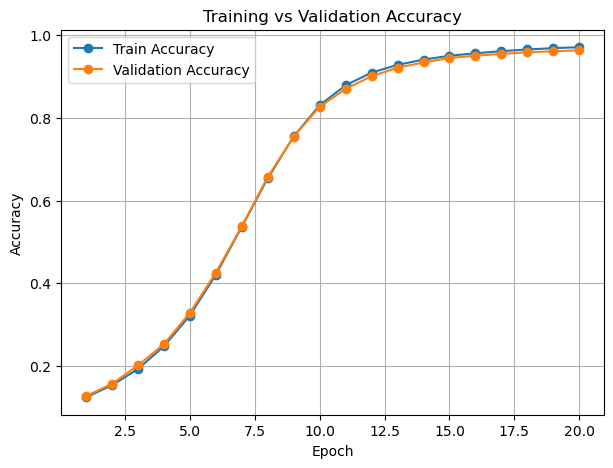

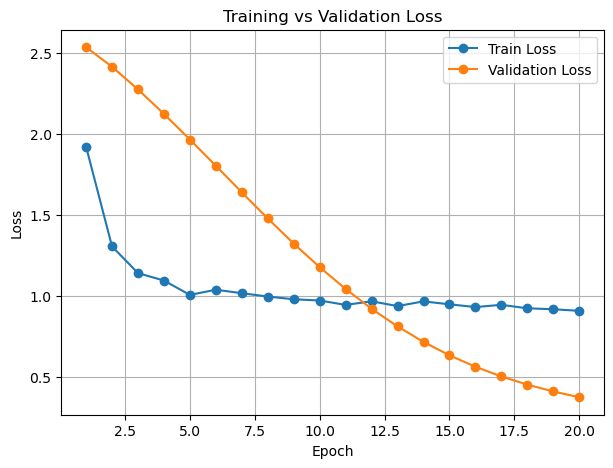

In [11]:
import matplotlib.pyplot as plt

epochs_axis = history["epoch"]

plt.figure(figsize=(7,5))
plt.plot(epochs_axis, history["train_clean_acc"], marker='o', label="Train Accuracy")
plt.plot(epochs_axis, history["val_acc"],       marker='o', label="Validation Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.grid(True); plt.legend()
plt.show()

plt.figure(figsize=(7,5))
plt.plot(epochs_axis, history["train_loss"],       marker='o', label="Train Loss")
plt.plot(epochs_axis, history["val_loss"],         marker='o', label="Validation Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.grid(True); plt.legend()
plt.show()

In [12]:
if os.path.isfile(SAVE_BEST_TO):
    checkpoint = torch.load(SAVE_BEST_TO, map_location=device)
    if hasattr(ema, "module"):
        ema.module.load_state_dict(checkpoint["model_state"])
        eval_model = ema.module
    else:
        model.load_state_dict(checkpoint["model_state"])
        eval_model = model
    print(f"Loaded best checkpoint from epoch {checkpoint.get('epoch')} with val_acc={checkpoint.get('best_val_acc'):.4f}")
else:
    eval_model = ema.module if hasattr(ema, "module") else model

@torch.no_grad()
def evaluate_model(model, loader):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    total_n = 0
    for images, targets in loader:
        images, targets = images.to(device, non_blocking=True), targets.to(device, non_blocking=True)
        with torch.amp.autocast(device_type="cuda", enabled=(device.type == "cuda")):
            outputs = model(images)
            loss = criterion_val(outputs, targets)
        bs = images.size(0)
        total_loss += loss.item() * bs
        total_acc += (outputs.argmax(dim=1) == targets).float().sum().item()
        total_n += bs
    return total_loss / total_n, total_acc / total_n

test_loss, test_acc = evaluate_model(eval_model, test_loader)
print(f"TEST (EMA): loss={test_loss:.4f}, acc={test_acc:.4f}")

C:\Users\Liang\AppData\Local\Temp\ipykernel_13956\2752730535.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(SAVE_BEST_TO, map_location=device)


Loaded best checkpoint from epoch 20 with val_acc=0.9637
TEST (EMA): loss=0.3768, acc=0.9637


In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

eval_model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, targets in test_loader:
        images = images.to(device, non_blocking=True)
        outputs = eval_model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(targets.numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_targets)

print("y_pred shape:", y_pred.shape, "y_true shape:", y_true.shape)

y_pred shape: (10000,) y_true shape: (10000,)


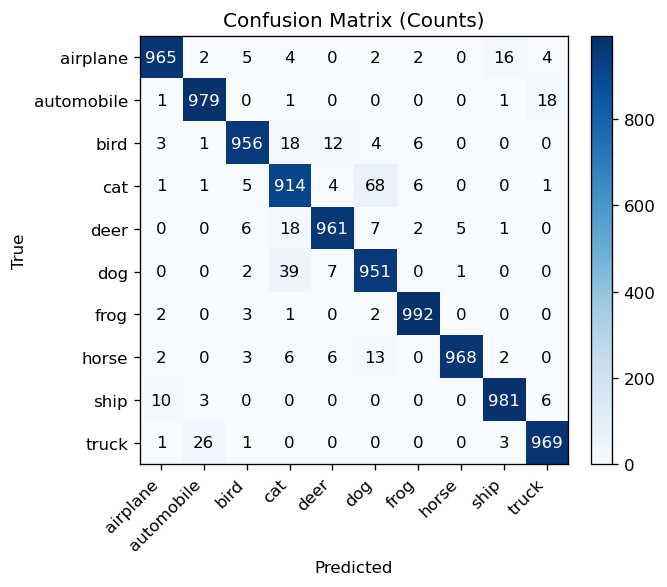

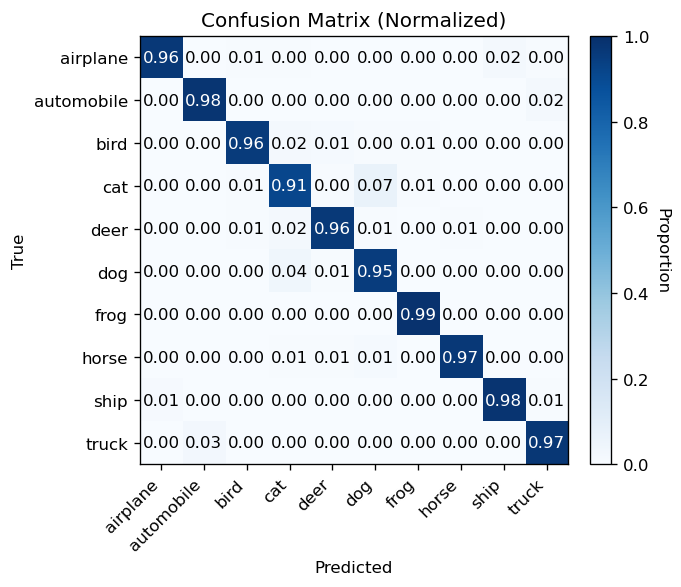

In [14]:
import matplotlib.pyplot as plt

classes = test_set.classes if hasattr(test_set, 'classes') else [str(i) for i in range(10)]
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))

cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True).clip(min=1)

plt.figure(figsize=(6, 5), dpi=120)
im = plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix (Counts)")
plt.xlabel("Predicted"); plt.ylabel("True")
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, ha="right")
plt.yticks(tick_marks, classes)
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)

thresh = cm.max() / 2.0 if cm.size else 0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=10)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5), dpi=120)
im = plt.imshow(cm_norm, interpolation='nearest', cmap='Blues', vmin=0, vmax=1)
plt.title("Confusion Matrix (Normalized)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(tick_marks, classes, rotation=45, ha="right")
plt.yticks(tick_marks, classes)
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label("Proportion", rotation=270, labelpad=12)

for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        plt.text(j, i, f"{cm_norm[i, j]:.2f}",
                 ha="center", va="center",
                 color="white" if cm_norm[i, j] > 0.5 else "black",
                 fontsize=10)
plt.tight_layout()
plt.show()

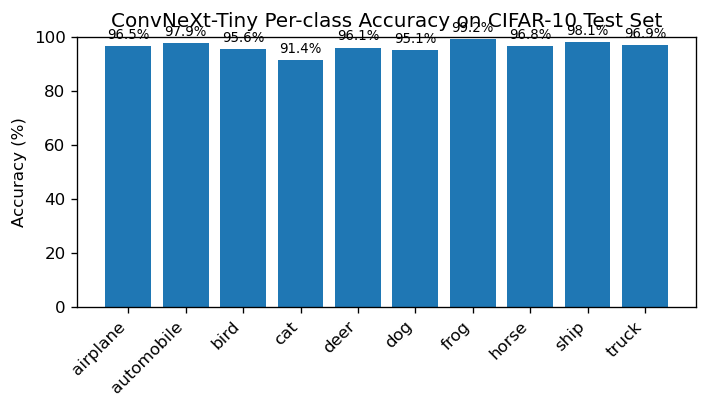

In [15]:
correct_per_class = cm.diagonal()
support_per_class = cm.sum(axis=1)
acc_per_class = correct_per_class / np.maximum(1, support_per_class) * 100.0

plt.figure(figsize=(6, 3.5), dpi=120)
plt.bar(classes, acc_per_class)
plt.ylim(0, 100)
plt.ylabel("Accuracy (%)")
plt.title("ConvNeXt-Tiny Per-class Accuracy on CIFAR-10 Test Set")
plt.xticks(rotation=45, ha="right")
for i, v in enumerate(acc_per_class):
    plt.text(i, v + 1.5, f"{v:.1f}%", ha="center", va="bottom", fontsize=8)
plt.tight_layout()
plt.show()

In [16]:
import pandas as pd

eval_model.eval()

all_preds = []
all_ids = []

with torch.no_grad():
    for idx, (images, targets) in enumerate(test_loader):
        images = images.to(device, non_blocking=True)
        with torch.amp.autocast(device_type="cuda", enabled=(device.type == "cuda")):
            outputs = eval_model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        batch_start = idx * test_loader.batch_size
        batch_ids = list(range(batch_start, batch_start + len(preds)))
        all_preds.extend(preds)
        all_ids.extend(batch_ids)

class_names = test_set.classes if hasattr(test_set, "classes") else [str(i) for i in range(10)]
predicted_labels = [class_names[p] for p in all_preds]

df = pd.DataFrame({"id": all_ids, "predicted_label": predicted_labels})
df = df.sort_values("id").reset_index(drop=True)
csv_path = "test_predictions_cifar10.csv"
df.to_csv(csv_path, index=False)
print(f"Saved test predictions to {csv_path} with {len(df)} rows")
df.head()

Saved test predictions to test_predictions_cifar10.csv with 10000 rows


,id,predicted_label
0,0,cat
1,1,ship
2,2,ship
3,3,airplane
4,4,frog


In [17]:
import numpy as np
from sklearn.metrics import classification_report

def _compute_preds_targets(model, loader, device):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for images, t in loader:
            images = images.to(device, non_blocking=True)
            out = model(images)
            preds.append(out.argmax(1).cpu().numpy())
            targets.append(t.numpy())
    return np.concatenate(preds), np.concatenate(targets)

if 'y_true' not in globals() or 'y_pred' not in globals():
    y_pred, y_true = _compute_preds_targets(eval_model, test_loader, device)

names = test_set.classes if hasattr(test_set, "classes") else [str(i) for i in range(len(np.unique(y_true)))]

acc = (y_pred == y_true).mean()
print(f"Test accuracy: {acc:.4f}\n")
print("Classification report:")
print(classification_report(y_true, y_pred, target_names=names, digits=4))

Test accuracy: 0.9636

Classification report:
              precision    recall  f1-score   support

    airplane     0.9797    0.9650    0.9723      1000
  automobile     0.9674    0.9790    0.9732      1000
        bird     0.9745    0.9560    0.9652      1000
         cat     0.9131    0.9140    0.9135      1000
        deer     0.9707    0.9610    0.9658      1000
         dog     0.9083    0.9510    0.9292      1000
        frog     0.9841    0.9920    0.9880      1000
       horse     0.9938    0.9680    0.9807      1000
        ship     0.9771    0.9810    0.9790      1000
       truck     0.9709    0.9690    0.9700      1000

    accuracy                         0.9636     10000
   macro avg     0.9640    0.9636    0.9637     10000
weighted avg     0.9640    0.9636    0.9637     10000

